# Deploy NGC pytorch model to SageMaker

For a description of the model you can look here: https://ngc.nvidia.com/catalog/model-scripts/nvidia:ssd_for_pytorch

Let's get started by downloading an SSD model from NVIDIA

In [3]:
!wget https://api.ngc.nvidia.com/v2/models/nvidia/ssdpyt_fp32/versions/2/files/nvidia_ssdpyt_fp32_190826.pt

--2020-05-09 23:27:08--  https://api.ngc.nvidia.com/v2/models/nvidia/ssdpyt_fp32/versions/2/files/nvidia_ssdpyt_fp32_190826.pt
Resolving api.ngc.nvidia.com (api.ngc.nvidia.com)... 54.186.237.130, 52.41.113.93
Connecting to api.ngc.nvidia.com (api.ngc.nvidia.com)|54.186.237.130|:443... connected.
HTTP request sent, awaiting response... 302 
Location: https://s3.us-west-2.amazonaws.com/prod-model-registry-ngc-bucket/org/nvidia/models/ssdpyt_fp32/versions/2/files/nvidia_ssdpyt_fp32_190826.pt?response-content-disposition=attachment%3B%20filename%3D%22nvidia_ssdpyt_fp32_190826.pt%22&response-content-type=application%2Foctet-stream&X-Amz-Security-Token=IQoJb3JpZ2luX2VjEL%2F%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FwEaCXVzLXdlc3QtMiJHMEUCIQCF8I7FQPYN%2BSTD6L3Ru2ODzOv0%2F9%2Bw7tHaSnZ8fqaFagIgPxJFk8Sii8q1%2FcEHO04MwYOo1NrZkZ44IRV1FBFQZBQqvQMI%2BP%2F%2F%2F%2F%2F%2F%2F%2F%2F%2FARACGgw3ODkzNjMxMzUwMjciDJqsO%2FoKPsQtPnHd6SqRAwtduzLkrri%2Fbf2zRLnl9L1HBvUzcea5H8effi%2BILv1sGEcfNOCXeNqbYuz%2FHLcZSnrL1AIV4U%2FbZSp

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch.model import PyTorchModel
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import tarfile
import json
import torch
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from utils import *

sess = sagemaker.Session()
role = get_execution_role()
bucket = sess.default_bucket() # can replace with your own s3 bucket! 

Now that we have imported the necessary packages, we need to take the model file we downloaded and make it into a tarball. This is the format that Sagemaker needs the model to be in to deploy it to an endpoint.

In [4]:
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('nvidia_ssdpyt_fp32_190826.pt')

Our next step is to upload this data to s3 

In [5]:
modelpath = sess.upload_data(
    path='model.tar.gz', bucket=bucket,
    key_prefix='sagemaker-pytorch/input')

Now we are going to use the built in Jupyter magic command to write our transform_script.py. This file is going to tell our endpoint how to load our model, handle input data, and make predictions. We first initialize the model architecture, which is a SSD300 object detector based on a ResNet50 backbone. 

In [31]:
%%writefile transform_script.py

import torch
import os
import numpy as np

import torch.nn as nn
from torchvision.models.resnet import resnet18, resnet34, resnet50, resnet101, resnet152

class ResNet(nn.Module):
    def __init__(self, backbone='resnet50', backbone_path=None):
        super().__init__()
        if backbone == 'resnet18':
            backbone = resnet18(pretrained=not backbone_path)
            self.out_channels = [256, 512, 512, 256, 256, 128]
        elif backbone == 'resnet34':
            backbone = resnet34(pretrained=not backbone_path)
            self.out_channels = [256, 512, 512, 256, 256, 256]
        elif backbone == 'resnet50':
            backbone = resnet50(pretrained=not backbone_path)
            self.out_channels = [1024, 512, 512, 256, 256, 256]
        elif backbone == 'resnet101':
            backbone = resnet101(pretrained=not backbone_path)
            self.out_channels = [1024, 512, 512, 256, 256, 256]
        else:  # backbone == 'resnet152':
            backbone = resnet152(pretrained=not backbone_path)
            self.out_channels = [1024, 512, 512, 256, 256, 256]
        if backbone_path:
            backbone.load_state_dict(torch.load(backbone_path))

        self.feature_extractor = nn.Sequential(*list(backbone.children())[:7])

        conv4_block1 = self.feature_extractor[-1][0]

        conv4_block1.conv1.stride = (1, 1)
        conv4_block1.conv2.stride = (1, 1)
        conv4_block1.downsample[0].stride = (1, 1)

    def forward(self, x):
        x = self.feature_extractor(x)
        return x

class SSD300(nn.Module):
    def __init__(self, backbone=ResNet('resnet50')):
        super().__init__()

        self.feature_extractor = backbone

        self.label_num = 81  # number of COCO classes
        self._build_additional_features(self.feature_extractor.out_channels)
        self.num_defaults = [4, 6, 6, 6, 4, 4]
        self.loc = []
        self.conf = []

        for nd, oc in zip(self.num_defaults, self.feature_extractor.out_channels):
            self.loc.append(nn.Conv2d(oc, nd * 4, kernel_size=3, padding=1))
            self.conf.append(nn.Conv2d(oc, nd * self.label_num, kernel_size=3, padding=1))

        self.loc = nn.ModuleList(self.loc)
        self.conf = nn.ModuleList(self.conf)
        self._init_weights()

    def _build_additional_features(self, input_size):
        self.additional_blocks = []
        for i, (input_size, output_size, channels) in enumerate(zip(input_size[:-1], input_size[1:], [256, 256, 128, 128, 128])):
            if i < 3:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, padding=1, stride=2, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )
            else:
                layer = nn.Sequential(
                    nn.Conv2d(input_size, channels, kernel_size=1, bias=False),
                    nn.BatchNorm2d(channels),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(channels, output_size, kernel_size=3, bias=False),
                    nn.BatchNorm2d(output_size),
                    nn.ReLU(inplace=True),
                )

            self.additional_blocks.append(layer)

        self.additional_blocks = nn.ModuleList(self.additional_blocks)

    def _init_weights(self):
        layers = [*self.additional_blocks, *self.loc, *self.conf]
        for layer in layers:
            for param in layer.parameters():
                if param.dim() > 1: nn.init.xavier_uniform_(param)

    # Shape the classifier to the view of bboxes
    def bbox_view(self, src, loc, conf):
        ret = []
        for s, l, c in zip(src, loc, conf):
            ret.append((l(s).view(s.size(0), 4, -1), c(s).view(s.size(0), self.label_num, -1)))

        locs, confs = list(zip(*ret))
        locs, confs = torch.cat(locs, 2).contiguous(), torch.cat(confs, 2).contiguous()
        return locs, confs

    def forward(self, x):
        x = self.feature_extractor(x)

        detection_feed = [x]
        for l in self.additional_blocks:
            x = l(x)
            detection_feed.append(x)

        # Feature Map 38x38x4, 19x19x6, 10x10x6, 5x5x6, 3x3x4, 1x1x4
        locs, confs = self.bbox_view(detection_feed, self.loc, self.conf)

        # For SSD 300, shall return nbatch x 8732 x {nlabels, nlocs} results, to get bboxes, use decoder
        return locs, confs

# this function tells the endpoint how to make predictions and how to package them to send back
def predict_fn(input_data, model):
    # run prediction
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        pred = model(input_data)
    #pred1, pred2 = pred[0].detach().cpu().numpy(),pred[1].detach().cpu().numpy()
    pred_dict = {'pred1':pred[0].detach().cpu().numpy(), 'pred2':pred[1].detach().cpu().numpy()}
    return pred_dict
        
# this function loads our model weights from s3, or if that fails, from the NGC repo
def model_fn(model_dir):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SSD300(backbone=ResNet('resnet50'))
    try:
        model_weights = torch.load(os.path.join(model_dir, 'nvidia_ssdpyt_fp32_190826.pt'), map_location='cpu')['model']
        model.to('cpu')
        model.load_state_dict(model_weights)
    except:
        print('using fallback model loading')
        os.system('wget https://api.ngc.nvidia.com/v2/models/nvidia/ssdpyt_fp32/versions/2/files/nvidia_ssdpyt_fp32_190826.pt')
        model_weights = torch.load(os.path.join('nvidia_ssdpyt_fp32_190826.pt'), map_location='cpu')['model']
        model.to('cpu')
        model.load_state_dict(model_weights)
    model.eval()
    return model 

# this function handles our input data and reshapes it back into an image
def input_fn(request_body, request_content_type):
    """this function handles our input data and reshapes it back into an image"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if(request_content_type == 'application/x-npy'):
        try:
            input_data = np.frombuffer(request_body, dtype=np.float64)
        except:
            input_data = np.array(request_body, dtype=np.float64)
    try:
        input_data = torch.tensor(np.reshape(input_data,(1,3,300,300)), dtype=torch.float32, device=device) # this needs to be a torch tensor 
    except:
        input_data = torch.tensor(np.reshape(input_data[16:],(1,3,300,300)), dtype=torch.float32, device=device) # this needs to be a torch tensor 
    return input_data

Overwriting transform_script.py


Use the SageMaker PyTorchModel to instantiate and deploy the model onto a GPU instance

In [32]:
pytorch_model = PyTorchModel(model_data=modelpath, role=role,
                             entry_point='transform_script.py',
                             framework_version='1.4.0')

predictor = pytorch_model.deploy(instance_type='ml.g4dn.2xlarge',
                                 initial_instance_count=1,
                                 wait=True,
                                 endpoint_name='torch-ssd-ngc-model')

---------------!

### Download, convert and send images for inference

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


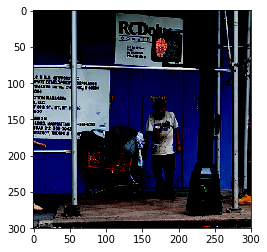

In [60]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg'
]

img = imread(uris[2])
#img = resize(img, (300,300,3))
img = rescale(img, 300, 300)
img = crop_center(img, 300, 300)
img = normalize(img)
plt.imshow(img)


In [61]:
#img = np.array(img, dtype=np.float64)

result = predictor.predict(img.tobytes())

# import boto3
# runtime_client = boto3.client('runtime.sagemaker')
# response = runtime_client.invoke_endpoint(EndpointName='torch-ssd-ngc-model',
#                                        ContentType='application/x-npy',
#                                        Body=img.tobytes())
# response = eval(response['Body'].read().decode('utf-8'))

result

array({'pred1': array([[[ 0.571932  ,  1.4820659 ,  0.8467874 , ...,  0.18732539,
          0.07604121,  0.4031073 ],
        [ 0.43436772,  0.7961598 ,  0.74914354, ...,  0.16492546,
          0.270355  ,  0.12804198],
        [-4.1770425 , -6.25521   , -6.9900794 , ..., -0.2911414 ,
         -0.14398116,  1.7102379 ],
        [-3.19998   , -4.6099863 , -5.7564645 , ...,  0.15257706,
          2.3180227 , -0.03434539]]], dtype=float32), 'pred2': array([[[ 7.9814005 ,  8.855176  ,  8.991283  , ...,  6.294547  ,
          6.272207  ,  6.300516  ],
        [ 2.058437  ,  2.680497  ,  2.7132957 , ...,  1.4554498 ,
          1.801609  ,  1.4739025 ],
        [-0.49131912, -0.4984903 , -0.33672965, ..., -0.50752103,
         -0.42051622, -0.5337124 ],
        ...,
        [-0.22257666, -0.21190922, -0.09732534, ..., -1.1557548 ,
         -1.0803659 , -1.2866592 ],
        [-0.9976299 , -1.3726819 , -1.4608448 , ..., -1.4031268 ,
         -1.415388  , -1.3680032 ],
        [-0.5312505 , -0.7

In [62]:
dboxes = dboxes300_coco()
encoder = Encoder(dboxes)
#result = (result.tolist()['pred1'],result.tolist()['pred2'])
# encoded = encoder.decode_batch(ploc, plabel, criteria=0.5, max_output=20)
# ploc, plabel = [val.float() for val in pred]
# encoded = encoder.decode_batch(ploc, plabel, criteria=0.5, max_output=20)
encoded = encoder.decode_batch(torch.tensor(result.tolist()['pred1']), torch.tensor(result.tolist()['pred2']), criteria=0.5, max_output=20)

In [63]:
encoded

[[tensor([]), tensor([]), tensor([])]]

In [64]:
bboxes, classes, confidences = [x.detach().cpu().numpy() for x in encoded[0]]

In [66]:
best = np.argwhere(confidences > 0.1).squeeze()
best

array([], dtype=int64)

In [22]:
!curl -O http://images.cocodataset.org/annotations/annotations_trainval2017.zip; unzip annotations_trainval2017.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  241M  100  241M    0     0  93.0M      0  0:00:02  0:00:02 --:--:-- 93.0M
Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [23]:
#!bash download_cocodata.sh
json_file = 'annotations/instances_val2017.json'
with open(json_file,'r') as COCO:
    js = json.loads(COCO.read())
class_names = [ category['name'] for category in js['categories'] ]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


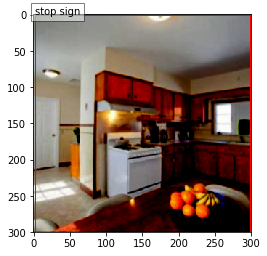

In [59]:
fig,ax = plt.subplots(1)
ax.imshow(img)
if(best.shape==()):
    best = [best]
for idx in best:
    left, top, right, bottom = bboxes[idx]
    x, y, w, h = [val*300 for val in [left, top, right-left, bottom-top]]
    rect = patches.Rectangle((x, y),w,h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, class_names[classes[idx]-1], bbox=dict(facecolor='white', alpha=0.5))
plt.show()

## Cleanup

Remove model and delete endpoint

In [67]:
!rm nvidia_ssdpyt_fp32_190826.pt model.tar.gz annotations_trainval2017.zip
!rm -rf annotations


rm: cannot remove ‘nvidia_ssdpyt_fp32_190826.pt’: No such file or directory
rm: cannot remove ‘model.tar.gz’: No such file or directory
rm: cannot remove ‘annotations_trainval2017.zip’: No such file or directory


In [40]:
predictor.delete_endpoint()